# Robust model

## Data preparation

In [1]:
# required imports and set seeds
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datetime import datetime

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(7843)
torch.manual_seed(7843)

In [2]:
# transform required for vgg
# furthermore we use standard data augmentation for the training set
# to make the model more robust and also ideally a cat is a cat even after being rotated with 10 degrees :)
# randomly ordered rotation, brightness and horizontal flip

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomOrder([
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
        ]),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=train_transform,
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=test_transform,
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


Small batch training tend to out perform large batch training at sharp minimas, see [here](https://arxiv.org/pdf/1609.04836.pdf).

In [4]:
# batch size is bascially defined by the memory of my gpu
batch_size = 16
unused_indices = set(range(train_dataset.data.shape[0]))

# random subselection of images, not the full subset
rand_indices = np.random.choice(range(train_dataset.data.shape[0]), 750, replace=False)
unused_indices -= set(rand_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(rand_indices)
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

Quick check on the distribution of the labels of the training dataset. Class 4 is a bit underreppresented within this random sample, but I am going to use active learning with margin sampling. Thus it should be not an issue as it would be improved, if required.

In [5]:
pd.Series(np.array(train_dataset.targets)[rand_indices]).value_counts()

5    97
8    79
0    78
7    74
2    74
6    73
9    71
4    68
3    68
1    68
dtype: int64

---
## Model

In [6]:
model = torchvision.models.vgg19(pretrained=True)

# freeze vgg weights
for param in model.parameters():
    param.requires_grad = False
    
# extract number of features
n_features = model.classifier[0].in_features

In [7]:
# bit varied head
class vgg_head(nn.Module):
    def __init__(self, n_features, K):
        super(vgg_head, self).__init__()
        
        self.fc = nn.Sequential(nn.Linear(n_features, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, K))
        
    def forward(self, x):
        outputs = self.fc(x)
        return outputs, torch.ones(outputs.shape, dtype=outputs.dtype)
    
model.classifier = vgg_head(n_features, K)

In [8]:
# look for gpu
# move model to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

---
## Training

In [9]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters())

In [10]:
# fgsm attack code
def fgsm_attack(image, epsilon, data_grad):
    # collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # standardise the data within the batch
    perturbed_image = (perturbed_image - torch.mean(perturbed_image,axis=(0,2,3)).view(1,-1,1,1)) / torch.std(perturbed_image,axis=(0,2,3)).view(1,-1,1,1)
    # return the perturbed image
    return perturbed_image

Further augment the data with fgsm attack, this should result in a more robust network, see [here](https://arxiv.org/pdf/1706.06083.pdf) and [here](https://arxiv.org/pdf/1511.06306.pdf). I am a bit uncertain with the standardisation of the perturbed image as in the implementations I have seen they do not renormalise it, but rather force them to be within the range of $[0,1]$, which is not exactly the same as above.

In [11]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)

            #### augment data with fgsm attack
            inputs.requires_grad = True

            outputs, _ = model(inputs)

            loss = F.nll_loss(outputs, targets)
            model.zero_grad()
            loss.backward()
            inputs_grad = inputs.grad.data

            inputs = fgsm_attack(inputs, np.random.uniform(high=0.025), inputs_grad)
            ####
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward calculation and loss
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # backward propagation and optimize
            loss.backward()
            optimizer.step()
            
            # store loss on batch
            train_loss.append(loss.item())

        # train loss
        train_loss = np.mean(train_loss) # a little misleading
        
        # repeat for test set
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # save losses for every epoch
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        # print train and test details
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

In [12]:
# actual training
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epochs=20,
)

train_losses, test_losses = list(train_losses), list(test_losses)

Epoch 1/20, Train Loss: 6.9602,           Test Loss: 1.6858, Duration: 0:00:46.428260
Epoch 2/20, Train Loss: 2.2472,           Test Loss: 1.5384, Duration: 0:00:46.432317
Epoch 3/20, Train Loss: 2.1514,           Test Loss: 1.3617, Duration: 0:00:46.817790
Epoch 4/20, Train Loss: 2.0314,           Test Loss: 1.2669, Duration: 0:00:49.303099
Epoch 5/20, Train Loss: 1.9823,           Test Loss: 1.1701, Duration: 0:00:46.971019
Epoch 6/20, Train Loss: 1.9252,           Test Loss: 1.2387, Duration: 0:00:46.749149
Epoch 7/20, Train Loss: 1.8660,           Test Loss: 1.1187, Duration: 0:00:46.865258
Epoch 8/20, Train Loss: 1.9152,           Test Loss: 1.0609, Duration: 0:00:46.350771
Epoch 9/20, Train Loss: 1.8571,           Test Loss: 1.0564, Duration: 0:00:46.567048
Epoch 10/20, Train Loss: 1.8192,           Test Loss: 1.1249, Duration: 0:00:47.098081
Epoch 11/20, Train Loss: 1.8314,           Test Loss: 1.0146, Duration: 0:00:46.952275
Epoch 12/20, Train Loss: 1.7737,           Test Loss

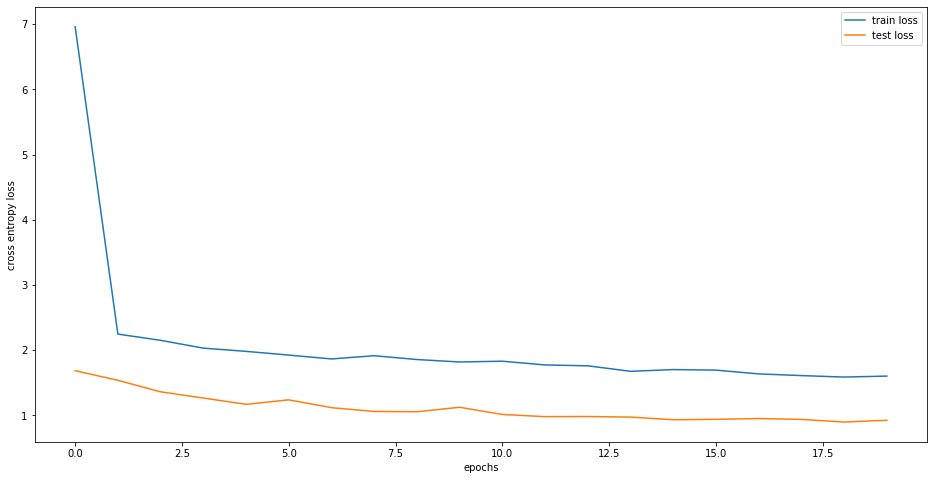

In [13]:
# plot losses during random sample training
plt.figure(figsize=(16,8))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.legend()
plt.show()

---
## Active learning with margin sampling

Epoch 1/5, Train Loss: 1.6111,           Test Loss: 0.8543, Duration: 0:00:46.649908
Epoch 2/5, Train Loss: 1.5532,           Test Loss: 0.8685, Duration: 0:00:46.755029
Epoch 3/5, Train Loss: 1.5599,           Test Loss: 0.8836, Duration: 0:00:46.714753
Epoch 4/5, Train Loss: 1.5267,           Test Loss: 0.8706, Duration: 0:00:47.345807
Epoch 5/5, Train Loss: 1.4782,           Test Loss: 0.8848, Duration: 0:00:47.759500
Epoch 1/5, Train Loss: 1.5774,           Test Loss: 0.8559, Duration: 0:00:47.597870
Epoch 2/5, Train Loss: 1.4830,           Test Loss: 0.8596, Duration: 0:00:47.553135
Epoch 3/5, Train Loss: 1.4932,           Test Loss: 0.8822, Duration: 0:00:47.748900
Epoch 4/5, Train Loss: 1.4553,           Test Loss: 0.8394, Duration: 0:00:47.592435
Epoch 5/5, Train Loss: 1.4330,           Test Loss: 0.9396, Duration: 0:00:47.525086
Epoch 1/5, Train Loss: 1.4871,           Test Loss: 0.8869, Duration: 0:00:48.118897
Epoch 2/5, Train Loss: 1.5029,           Test Loss: 0.8806, Durat

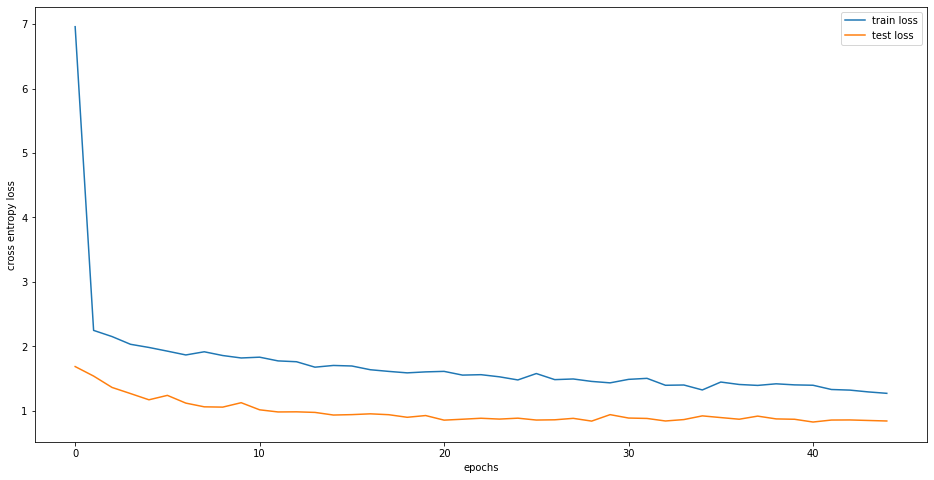

In [14]:
for _ in range(5):
    
    # first we calculate the differences between the predicted values for most and second most probable class
    # we are going to feed in 25-25 new images of those into the dataset randomly and do this until
    # 1000 images is reached, thus the 5 loop
    
    # get average distance between the first and second predicted class
    margins = {}

    n_correct = 0.
    n_total = 0.
    for inputs, targets in test_loader:
        
        inputs, targets = inputs.to(device), targets.to(device)

        outputs, _ = model(inputs)

        values, indices = torch.topk(outputs,2,1)

        for diff, labels in zip((values[:,0] - values[:,1]).data.cpu().numpy(), torch.sort(indices)[0].data.cpu().numpy()):
            lab = str(labels[0])+'-'+str(labels[1])
            if lab in margins.keys():
                margins[lab].append(diff)
            else:
                margins[lab] = [diff]

    for key in margins.keys():
        margins[key] = np.mean(margins[key])

    ######################
    # labels of the newly extended dataset of the with the minimal distance classes

    marginal_labels = np.array(min(margins, key=margins.get).split('-')).astype(int)
    new_labels = 0
    while True:
        choice = np.random.choice(list(unused_indices), 1, replace=False)
        choice_label = np.array(train_dataset.targets)[choice][0]
        if choice_label in marginal_labels:
            new_labels += 1
            unused_indices -= {choice[0]}
        else:
            pass

        if new_labels == 50:
            break

    extended_labels = list(set(range(train_dataset.data.shape[0])) - unused_indices)

    ####################
    # update train loader
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.sampler.SubsetRandomSampler(extended_labels)
    )

    ####################
    # train the model with the extended dataset

    tr_ls, te_ls = batch_gd(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        epochs=5,
    )
    
    tr_ls, te_ls = list(tr_ls), list(te_ls)
    
    train_losses.extend(tr_ls)
    test_losses.extend(te_ls)
    
# plot training results after active learning
plt.figure(figsize=(16,8))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.legend()
plt.savefig('./images/robust_model_training.png')
plt.show()

---
## Results

I will use pytorch provided [FGSM attack](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) to test its robustness, furthermore accuracy for the normal case ($\epsilon = 0.0$). There is a minor modification on the pytorch script, our data was not min-max scaled, but standardised, thus I standardised the results with respect to the batch. Though it must be said that within the batches I have seen larger deviations for the mean, I believe this could be solved using larger batches, however this is the maximum my vga can handle.

In addition as I used data augmentation when I loaded the training set I will have to load a new not augmented train dataset to see the results on it.

In [15]:
# not augmented train data
train_dataset_fixed = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=test_transform,
    download=True)
train_loader_fixed = torch.utils.data.DataLoader(
    train_dataset_fixed,
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified


In [16]:
# this is basically the same as the batch_gd function, but we do not optimise, just calculate the predictions at a given epsilon value

train_pert_res = []
test_pert_res = []

for epsilon in [0.,0.01,0.05,0.1,0.2,0.3]:

    n_correct_perturbed = 0.
    n_total_perturbed = 0.
    for inputs, targets in train_loader_fixed:
        # Move to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        inputs.requires_grad = True
        
        outputs, _= model(inputs)
        
        loss = F.nll_loss(outputs, targets)
        model.zero_grad()
        loss.backward()
        inputs_grad = inputs.grad.data

        perturbed_inputs = fgsm_attack(inputs, epsilon, inputs_grad)

        outputs, _ = model(perturbed_inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct_perturbed += (predictions == targets).sum().item()
        n_total_perturbed += targets.shape[0]

    train_acc_perturbed = n_correct_perturbed / n_total_perturbed

    n_correct_perturbed = 0.
    n_total_perturbed = 0.
    for inputs, targets in test_loader:
        # Move to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        inputs.requires_grad = True

        outputs, _= model(inputs)
        
        loss = F.nll_loss(outputs, targets)
        model.zero_grad()
        loss.backward()
        inputs_grad = inputs.grad.data

        perturbed_inputs = fgsm_attack(inputs, epsilon, inputs_grad)

        outputs, _ = model(perturbed_inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct_perturbed += (predictions == targets).sum().item()
        n_total_perturbed += targets.shape[0]

    test_acc_perturbed = n_correct_perturbed / n_total_perturbed

    print('Epsilon:',epsilon)
    print(f"Perturbed train acc: {train_acc_perturbed:.4f}, Perturbed test acc: {test_acc_perturbed:.4f}")
    
    train_pert_res.append(train_acc_perturbed)
    test_pert_res.append(test_acc_perturbed)

Epsilon: 0.0
Perturbed train acc: 0.7231, Perturbed test acc: 0.7105
Epsilon: 0.01
Perturbed train acc: 0.2493, Perturbed test acc: 0.2399
Epsilon: 0.05
Perturbed train acc: 0.3505, Perturbed test acc: 0.3424
Epsilon: 0.1
Perturbed train acc: 0.3741, Perturbed test acc: 0.3656
Epsilon: 0.2
Perturbed train acc: 0.3475, Perturbed test acc: 0.3468
Epsilon: 0.3
Perturbed train acc: 0.3009, Perturbed test acc: 0.2953


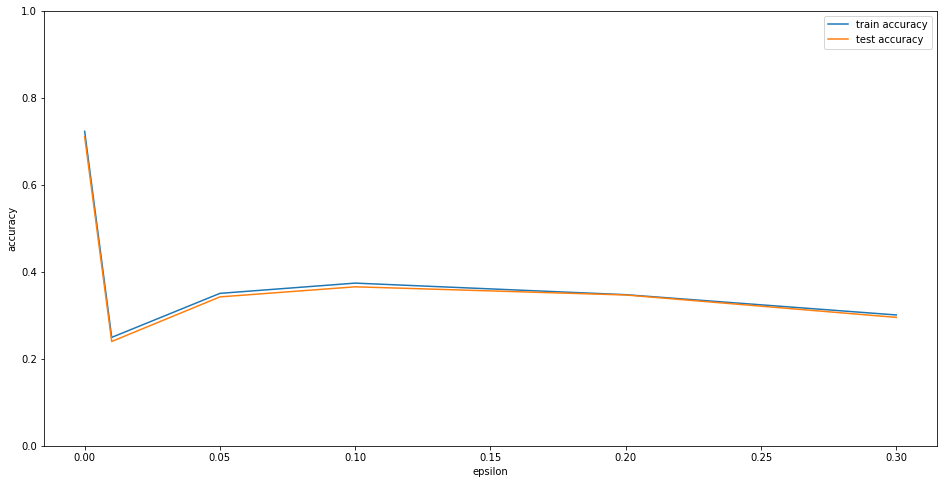

In [17]:
# fgsm durability
plt.figure(figsize=(16,8))
plt.plot([0.,0.01,0.05,0.1,0.2,0.3],train_pert_res,label='train accuracy')
plt.plot([0.,0.01,0.05,0.1,0.2,0.3],test_pert_res,label='test accuracy')
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.ylim([0,1])
plt.savefig('./images/robust_model_durability.png')
plt.show()

In [18]:
torch.save(model,'./models/robust_model.pt')

/home/eugenio/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type vgg_head. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
